# Working with tables

Table #1 - MALDA list from Marcus, annotated by him (from Cowell et al. (Science, 2018) paper)
<br>
Table #2 - list from Roberto (supplementary to Pf6 paper)
<br>
Table #3 - supplementary table from eLife paper (MalariaGEN Plasmodium falciparum Community Project, 2016)

In [5]:
table_MALDA_fn = '/Users/aa22/Documents/cloned_repo_environment/agam-report-base/MalDA SNPs Cowell_SM_table_S4_original_from_Marcus.xlsx' # MALDA list from Marcus
table_Pf6_sup_fn = '/Users/aa22/Desktop/Malaria_related/gene_statistics.txt'       # from here we need differentation scores, start & end
table_elife = '/Users/aa22/Documents/elife-08714-supp1-v2.xlsx'     # from here we only need Conservation score

In [6]:
%run _standard_imports.ipynb
%run _plotting_setup.ipynb
import zarr
import numcodecs
import pandas as pd
import numpy as np
zarr.codecs.codec_registry[numcodecs.MsgPack.codec_id] = numcodecs.MsgPack
zarr.codecs.codec_registry[numcodecs.Pickle.codec_id] = numcodecs.Pickle
import pybedtools as pbt

scikit-allel 1.2.0
python 3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.15.4
scipy 1.1.0
pandas 0.23.4
numexpr 2.6.8
pysam 0.15.2
petl 1.2.0
petlx 1.0.3
vcf 0.6.8
vcfnp 2.3.0
h5py 2.8.0
tables 3.4.4


Reading both tables

In [7]:
df_elife = pd.read_excel(table_elife)
df_elife.shape

(5407, 18)

In [8]:
df_Pf6_sup = pd.read_csv(table_Pf6_sup_fn, sep='\t')
df_Pf6_sup.shape

(5561, 8)

In [9]:
df_Pf6_sup.head()

,gene_id,gene_name,chrom,start,end,global_differentiation_score,local_differentiation_score,distance_to_higher_local_diff_score
0,PF3D7_0100100,VAR,Pf3D7_01_v3,29510,37126,NaN,NaN,NaN
1,PF3D7_0100200,RIF,Pf3D7_01_v3,38982,40207,NaN,NaN,NaN
2,PF3D7_0100300,VAR,Pf3D7_01_v3,42367,46507,NaN,NaN,NaN
3,PF3D7_0100400,RIF,Pf3D7_01_v3,50363,51636,NaN,NaN,NaN
4,PF3D7_0100600,RIF,Pf3D7_01_v3,53778,55006,NaN,NaN,NaN


(making a histogram of lds)

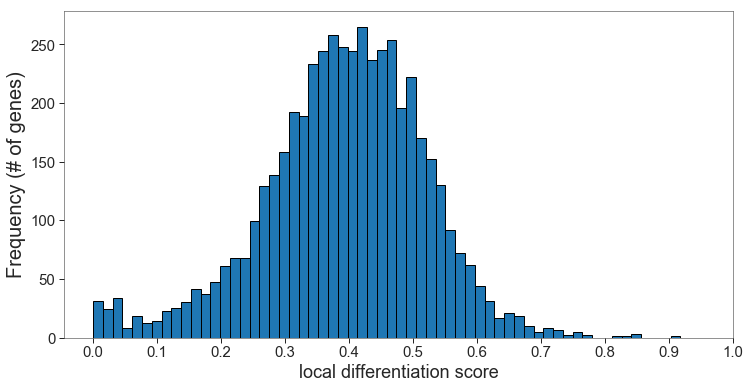

In [10]:
plt.figure(figsize=[12,6])
plt.hist(x=df_Pf6_sup['local_differentiation_score'].dropna(),bins=60,edgecolor='black', linewidth=1)
plt.xlabel('local differentiation score', fontsize=18)
plt.xticks([0.1*(i) for i in range(11)],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency (# of genes)', fontsize=20)
#plt.savefig('LDS_hist_MALDA.png')
plt.show()

Table #1 needs filtering
<br>
Filters for mutations: SNP, in the coding genome, non-synonymous, biallelic
<br>
We will filter after adding data to it (differentiation and conservation scores)

In [11]:
df_MALDA_annot = pd.read_excel(table_MALDA_fn, sheet_name='Annotated', header=1)
print(df_MALDA_annot.shape)

(866, 11)


In [12]:
df_MALDA_annot.head()

,Compound,Chromosome,Position,Gene_Name,Gene_Descrip,Type,Ref_Base,Alt_Base,Effect,Codon_Change,CodingChangeConversion
0,Atovaquone,Pf3D7_05_v3,686101,PF3D7_0516500,"""metabolite/drug transporter, putative""",SNP,C,T,intergenic,NaN,n.686101C>T
1,Atovaquone,Pf3D7_05_v3,686109,PF3D7_0516500,"""metabolite/drug transporter, putative""",SNP,G,T,intergenic,NaN,n.686109G>T
2,Atovaquone,Pf3D7_07_v3,402964,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,A,T,intergenic,NaN,n.402964A>T
3,Atovaquone,Pf3D7_07_v3,402965,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,T,G,intergenic,NaN,n.402965T>G
4,Atovaquone,Pf3D7_07_v3,402967,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,T,C,intergenic,NaN,n.402967T>C


In [13]:
# renaming because here gene name is a gene ID really (or transcript ID)
df_MALDA_annot = df_MALDA_annot.rename(columns = { 'Gene_Name' : 'Gene_ID'})    
df_MALDA_annot.head(10)

,Compound,Chromosome,Position,Gene_ID,Gene_Descrip,Type,Ref_Base,Alt_Base,Effect,Codon_Change,CodingChangeConversion
0,Atovaquone,Pf3D7_05_v3,686101,PF3D7_0516500,"""metabolite/drug transporter, putative""",SNP,C,T,intergenic,NaN,n.686101C>T
1,Atovaquone,Pf3D7_05_v3,686109,PF3D7_0516500,"""metabolite/drug transporter, putative""",SNP,G,T,intergenic,NaN,n.686109G>T
2,Atovaquone,Pf3D7_07_v3,402964,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,A,T,intergenic,NaN,n.402964A>T
3,Atovaquone,Pf3D7_07_v3,402965,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,T,G,intergenic,NaN,n.402965T>G
4,Atovaquone,Pf3D7_07_v3,402967,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,T,C,intergenic,NaN,n.402967T>C
5,Atovaquone,Pf3D7_12_v3,1198008,PF3D7_1229100,ABC+transporter%2C+%28CT+family%29+%28MRP2%29,SNP,C,G,non_synonymous_coding,Gca/Cca,A403P 1207G>C
6,Atovaquone,Pf3D7_12_v3,1193293,PF3D7_1229100,ABC+transporter%2C+%28CT+family%29+%28MRP2%29,INDEL,A,AT,frameshift_variant,aat/aaAt,N1974fs 5921dupA
7,GNF-Pf4492,Pf3D7_12_v3,529831,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,G,C,non_synonymous_coding,cCa/cGa,P990R 2969C>G
8,GNF-Pf4492,Pf3D7_12_v3,532169,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,C,T,non_synonymous_coding,Gca/Aca,A211T 631G>A
9,GNF-Pf4492,Pf3D7_12_v3,532193,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,T,G,non_synonymous_coding,Ata/Cta,I203L 607A>C


# Merging the tables
### Adding data

Merging the tables to obtain the full information about all the mutations before filtering them

Beginning to prepare extra data from table from supplementary to Pf6 paper(differentation scores) for adding to Table #1

Creating a dictionary {gene id : gene name} since in Table #1 there were no gene names

In [40]:
gene_id_to_name_dict = {}                      # a dictionary of gene ids and names of the genes corresponding
for geneid in df_MALDA_annot.Gene_ID:
    #print(geneid)
    if geneid in list(df_Pf6_sup['gene_id']):
        #print(gene_id_to_name_dict)
        #print('gene id is', geneid)       
        #print('present in table 2')   
        #print('gene name is', df_table_2['gene_name'][list(df_table_2['gene_id']).index(geneid)])
        gene_id_to_name_dict[geneid] = ((df_Pf6_sup['gene_name'][list(df_Pf6_sup['gene_id']).index(geneid)]))
    else:
        gene_id_to_name_dict[geneid] = 'nan'
        print(geneid, 'is not found in table 2')

PF3D7_0902700 is not found in table 2
PF3D7_1371600 is not found in table 2
PF3D7_0617500 is not found in table 2
PF3D7_0902700 is not found in table 2
PF3D7_0911500.1 is not found in table 2
PF3D7_1217100.1 is not found in table 2
PF3D7_1247000.1 is not found in table 2
PF3D7_1417400 is not found in table 2
PF3D7_1102000 is not found in table 2
PF3D7_1321500.1 is not found in table 2
PF3D7_1477900 is not found in table 2
PF3D7_1301000 is not found in table 2
PF3D7_1000700 is not found in table 2
PF3D7_1476900 is not found in table 2
PF3D7_1478400 is not found in table 2
PF3D7_1019500.1 is not found in table 2
PF3D7_1136500.1 is not found in table 2
PF3D7_1136500.1 is not found in table 2
PF3D7_1136500.1 is not found in table 2
PF3D7_1229900.1 is not found in table 2
PF3D7_0109900.1 is not found in table 2
exon is not found in table 2
PF3D7_1476900 is not found in table 2
PF3D7_1477900 is not found in table 2
nan is not found in table 2
nan is not found in table 2
nan is not found in t

In [41]:
#print(gene_id_to_name_dict)
#print(type(gene_id_to_name_dict['PF3D7_0523000'])) 
#len(gene_id_to_name_dict)

Now creating a similar dictionary {gene id: gene start}

In [42]:
gene_id_to_start_dict = {}
for geneid in df_MALDA_annot.Gene_ID:
    #print(geneid)
    if geneid in list(df_Pf6_sup['gene_id']):
        #print(gene_id_to_name_dict)
        #print('gene id is', geneid)       
        #print('present in table 2')   
        #print('gene name is', df_table_2['gene_name'][list(df_table_2['gene_id']).index(geneid)])
        gene_id_to_start_dict[geneid] = ((df_Pf6_sup['start'][list(df_Pf6_sup['gene_id']).index(geneid)]))
    else:
        gene_id_to_start_dict[geneid] = 'nan'

In [43]:
#print(gene_id_to_start_dict)
#len(gene_id_to_start_dict)

Same, creating a dictionary {gene id: gene end}

In [44]:
gene_id_to_end_dict = {}
for geneid in df_MALDA_annot.Gene_ID:
    #print(geneid)
    if geneid in list(df_Pf6_sup['gene_id']):
        #print(gene_id_to_name_dict)
        #print('gene id is', geneid)       
        #print('present in table 2')   
        #print('gene name is', df_table_2['gene_name'][list(df_table_2['gene_id']).index(geneid)])
        gene_id_to_end_dict[geneid] = ((df_Pf6_sup['end'][list(df_Pf6_sup['gene_id']).index(geneid)]))
    else:
        gene_id_to_end_dict[geneid] = 'nan'

In [45]:
#print(gene_id_to_end_dict)
#len(gene_id_to_end_dict)

Now creating dictionaries {gene id:
<br>
gds - global differentiation score
<br>
lds - local differentiation score
<br>
dthlds - distance to higher differentiation score }

In [46]:
gene_id_to_gds_dict = {}
for geneid in df_MALDA_annot.Gene_ID:
    #print(geneid)
    if geneid in list(df_Pf6_sup['gene_id']):
        #print(gene_id_to_name_dict)
        #print('gene id is', geneid)       
        #print('present in table 2')   
        #print('gene name is', df_table_2['gene_name'][list(df_table_2['gene_id']).index(geneid)])
        gene_id_to_gds_dict[geneid] = ((df_Pf6_sup['global_differentiation_score'][list(df_Pf6_sup['gene_id']).index(geneid)]))
    else:
        gene_id_to_gds_dict[geneid] = 'nan'

In [47]:
#print(gene_id_to_gds_dict)
#len(gene_id_to_gds_dict)

In [48]:
gene_id_to_lds_dict = {}
for geneid in df_MALDA_annot.Gene_ID:
    #print(geneid)
    if geneid in list(df_Pf6_sup['gene_id']):
        #print(gene_id_to_name_dict)
        #print('gene id is', geneid)       
        #print('present in table 2')   
        #print('gene name is', df_table_2['gene_name'][list(df_table_2['gene_id']).index(geneid)])
        gene_id_to_lds_dict[geneid] = ((df_Pf6_sup['local_differentiation_score'][list(df_Pf6_sup['gene_id']).index(geneid)]))
    else:
        gene_id_to_lds_dict[geneid] = 'nan'

In [49]:
#print(gene_id_to_lds_dict)
#len(gene_id_to_lds_dict)

In [50]:
gene_id_to_dthlds_dict = {}
for geneid in df_MALDA_annot.Gene_ID:
    #print(geneid)
    if geneid in list(df_Pf6_sup['gene_id']):
        #print(gene_id_to_name_dict)
        #print('gene id is', geneid)       
        #print('present in table 2')   
        #print('gene name is', df_table_2['gene_name'][list(df_table_2['gene_id']).index(geneid)])
        gene_id_to_dthlds_dict[geneid] = ((df_Pf6_sup['distance_to_higher_local_diff_score'][list(df_Pf6_sup['gene_id']).index(geneid)]))
    else:
        gene_id_to_dthlds_dict[geneid] = 'nan'

In [51]:
#print(gene_id_to_dthlds_dict)
#len(gene_id_to_dthlds_dict)

Also not forgetting to add the coservation score from eLife paper

In [52]:
gene_id_to_cons_score_dict = {}
for geneid in df_MALDA_annot.Gene_ID:
    #print(geneid)
    if geneid in list(df_elife['ID']):
        #print(gene_id_to_name_dict)
        #print('gene id is', geneid)       
        #print('present in table 2')   
        #print('gene name is', df_table_2['gene_name'][list(df_table_2['gene_id']).index(geneid)])
        gene_id_to_cons_score_dict[geneid] = ((df_elife['Conservation score'][list(df_elife['ID']).index(geneid)]))
    else:
        gene_id_to_cons_score_dict[geneid] = 'nan'
        #print(geneid,'is not in elife paper table')

In [53]:
#print(gene_id_to_cons_score_dict)
#len(gene_id_to_cons_score_dict)

Adding empty (for now) new columns (gene name, start, end, global differentiation score, local differentiation score and distance to local differentiation score) to filtered Table #1

In [54]:
df_merged = df_MALDA_annot
df_merged.shape

(866, 11)

In [55]:
df_merged['Gene Name'] = [None]*len(df_merged)
df_merged['start'] = [None]*len(df_merged)
df_merged['end'] = [None]*len(df_merged)
df_merged['global diff score'] = [None]*len(df_merged)
df_merged['local diff score'] = [None]*len(df_merged)
df_merged['distance to higher local diff score'] = [None]*len(df_merged)
df_merged['Conservation score'] = [None]*len(df_merged)

In [56]:
df_merged.head()        # the weird orded of indexes on the left comes from the filtering step, 
                                                        # not really sure how to fix it and if it's necessary

,Compound,Chromosome,Position,Gene_ID,Gene_Descrip,Type,Ref_Base,Alt_Base,Effect,Codon_Change,CodingChangeConversion,Gene Name,start,end,global diff score,local diff score,distance to higher local diff score,Conservation score
0,Atovaquone,Pf3D7_05_v3,686101,PF3D7_0516500,"""metabolite/drug transporter, putative""",SNP,C,T,intergenic,NaN,n.686101C>T,None,None,None,None,None,None,None
1,Atovaquone,Pf3D7_05_v3,686109,PF3D7_0516500,"""metabolite/drug transporter, putative""",SNP,G,T,intergenic,NaN,n.686109G>T,None,None,None,None,None,None,None
2,Atovaquone,Pf3D7_07_v3,402964,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,A,T,intergenic,NaN,n.402964A>T,None,None,None,None,None,None,None
3,Atovaquone,Pf3D7_07_v3,402965,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,T,G,intergenic,NaN,n.402965T>G,None,None,None,None,None,None,None
4,Atovaquone,Pf3D7_07_v3,402967,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,T,C,intergenic,NaN,n.402967T>C,None,None,None,None,None,None,None


In [57]:
df_merged.shape

(866, 18)

Now adding all of the values from the dictionaries (gene name, start, end, global differentiation score, local differentiation score, distance to higher local differentiation score)


In [60]:
%%time
for i in range(len(df_merged)):
    #print('gene id is', df_merged['Gene_ID'][i])
    geneid = df_merged['Gene_ID'][i]
    df_merged.loc[i,'Gene Name'] = gene_id_to_name_dict[geneid]
    df_merged.loc[i,'start'] = gene_id_to_start_dict[geneid]
    df_merged.loc[i,'end'] = gene_id_to_end_dict[geneid]
    df_merged.loc[i,'global diff score'] = gene_id_to_gds_dict[geneid]
    df_merged.loc[i,'local diff score'] = gene_id_to_lds_dict[geneid]
    df_merged.loc[i,'distance to higher local diff score'] = gene_id_to_dthlds_dict[geneid]
    df_merged.loc[i,'Conservation score'] = gene_id_to_cons_score_dict[geneid]

CPU times: user 2.71 s, sys: 43.6 ms, total: 2.76 s
Wall time: 2.75 s


In [63]:
print(df_merged.shape)

(866, 18)


In [64]:
df_merged.head()

,Compound,Chromosome,Position,Gene_ID,Gene_Descrip,Type,Ref_Base,Alt_Base,Effect,Codon_Change,CodingChangeConversion,Gene Name,start,end,global diff score,local diff score,distance to higher local diff score,Conservation score
0,Atovaquone,Pf3D7_05_v3,686101,PF3D7_0516500,"""metabolite/drug transporter, putative""",SNP,C,T,intergenic,NaN,n.686101C>T,MFS1,683708,685859,0.177963,0.292123,951,3.99321
1,Atovaquone,Pf3D7_05_v3,686109,PF3D7_0516500,"""metabolite/drug transporter, putative""",SNP,G,T,intergenic,NaN,n.686109G>T,MFS1,683708,685859,0.177963,0.292123,951,3.99321
2,Atovaquone,Pf3D7_07_v3,402964,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,A,T,intergenic,NaN,n.402964A>T,CRT,403222,406317,0.815128,0.853722,NaN,3.125
3,Atovaquone,Pf3D7_07_v3,402965,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,T,G,intergenic,NaN,n.402965T>G,CRT,403222,406317,0.815128,0.853722,NaN,3.125
4,Atovaquone,Pf3D7_07_v3,402967,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,T,C,intergenic,NaN,n.402967T>C,CRT,403222,406317,0.815128,0.853722,NaN,3.125


# Filtering MalDA list 

First let's look at what effects there are in general

In [65]:
print('column Effect', np.unique(df_merged['Effect'], return_counts=True))

column Effect (array(['CODON_CHANGE_PLUS_CODON_INSERTION', 'NON_SYNONYMOUS_CODING',
       'START_LOST', 'disruptive_inframe_deletion',
       'disruptive_inframe_insertion', 'frameshift_variant',
       'inframe_deletion', 'inframe_insertion', 'intergenic',
       'intergenic_region', 'intron_variant', 'non_coding_exon_variant\n',
       'non_synonymous_coding', 'splice_region_variant+intron_variant',
       'stop_gained', 'synonymous_variant'], dtype=object), array([  1,   2,   1,  17,  11,  26,  37,  22, 422,  45,  95,   1, 149,
         7,   9,  21]))


In [90]:
# FILTERING
df_filtered = df_merged[  (df_merged.Type == 'SNP')        # is a SNP                      
                    & ( (df_merged.Alt_Base == 'A') 
                         | (df_merged.Alt_Base == 'T') 
                         | (df_merged.Alt_Base == 'G') 
                         | (df_merged.Alt_Base == 'C') )   # is biallelic (no things like 'A,C' in Alt_Base column)
                    & (df_merged.Effect != 'intergenic')         # is not intergenic
                    & (df_merged.Effect != 'intergenic_region')  # same as above?
                                ]

In [91]:
print(df_filtered.shape)

(213, 18)


In [92]:
print(df_filtered.shape[0], 'biallelic SNPs in', len(set(list(df_filtered.Gene_ID))), 'genes')

213 biallelic SNPs in 130 genes


So in total there are 213 biallelic SNPs in MalDA in 130 genes
<br>
New (after filtering) effect variety:

In [93]:
print('column Effect', np.unique(df_filtered['Effect'], return_counts=True))

column Effect (array(['NON_SYNONYMOUS_CODING', 'START_LOST', 'intron_variant',
       'non_synonymous_coding', 'splice_region_variant+intron_variant',
       'stop_gained', 'synonymous_variant'], dtype=object), array([  2,   1,  30, 148,   2,   9,  21]))


In [94]:
df_filtered.head()

,Compound,Chromosome,Position,Gene_ID,Gene_Descrip,Type,Ref_Base,Alt_Base,Effect,Codon_Change,CodingChangeConversion,Gene Name,start,end,global diff score,local diff score,distance to higher local diff score,Conservation score
5,Atovaquone,Pf3D7_12_v3,1198008,PF3D7_1229100,ABC+transporter%2C+%28CT+family%29+%28MRP2%29,SNP,C,G,non_synonymous_coding,Gca/Cca,A403P 1207G>C,MRP2,1192888,1199214,0.441565,0.593533,136606,NaN
7,GNF-Pf4492,Pf3D7_12_v3,529831,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,G,C,non_synonymous_coding,cCa/cGa,P990R 2969C>G,ATP4,529005,532799,0.431161,0.56733,9568,3.59256
8,GNF-Pf4492,Pf3D7_12_v3,532169,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,C,T,non_synonymous_coding,Gca/Aca,A211T 631G>A,ATP4,529005,532799,0.431161,0.56733,9568,3.59256
9,GNF-Pf4492,Pf3D7_12_v3,532193,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,T,G,non_synonymous_coding,Ata/Cta,I203L 607A>C,ATP4,529005,532799,0.431161,0.56733,9568,3.59256
10,GNF-Pf4492,Pf3D7_12_v3,532240,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,G,A,non_synonymous_coding,gCt/gTt,A187Val 560C>T,ATP4,529005,532799,0.431161,0.56733,9568,3.59256


In [95]:
df_filtered.reset_index(inplace=True)   # to set a normal indexing after filtering

In [96]:
df_filtered = df_filtered.drop(columns=['index'])

In [97]:
df_filtered.shape

(213, 18)

In [98]:
df_filtered.head()

,Compound,Chromosome,Position,Gene_ID,Gene_Descrip,Type,Ref_Base,Alt_Base,Effect,Codon_Change,CodingChangeConversion,Gene Name,start,end,global diff score,local diff score,distance to higher local diff score,Conservation score
0,Atovaquone,Pf3D7_12_v3,1198008,PF3D7_1229100,ABC+transporter%2C+%28CT+family%29+%28MRP2%29,SNP,C,G,non_synonymous_coding,Gca/Cca,A403P 1207G>C,MRP2,1192888,1199214,0.441565,0.593533,136606,NaN
1,GNF-Pf4492,Pf3D7_12_v3,529831,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,G,C,non_synonymous_coding,cCa/cGa,P990R 2969C>G,ATP4,529005,532799,0.431161,0.56733,9568,3.59256
2,GNF-Pf4492,Pf3D7_12_v3,532169,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,C,T,non_synonymous_coding,Gca/Aca,A211T 631G>A,ATP4,529005,532799,0.431161,0.56733,9568,3.59256
3,GNF-Pf4492,Pf3D7_12_v3,532193,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,T,G,non_synonymous_coding,Ata/Cta,I203L 607A>C,ATP4,529005,532799,0.431161,0.56733,9568,3.59256
4,GNF-Pf4492,Pf3D7_12_v3,532240,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,G,A,non_synonymous_coding,gCt/gTt,A187Val 560C>T,ATP4,529005,532799,0.431161,0.56733,9568,3.59256


Writing to file:

In [99]:
writer = pd.ExcelWriter('/Users/aa22/Documents/cloned_repo_environment/agam-report-base/MALDA_lds.xlsx')
# exporting into excel file
df_filtered.to_excel(writer,'For_lds_filtering_all')
writer.save()

# Filtering candidates and transporters list

Now we will also separately filter out Marcus's picks - genes-candidates and transporters, which have been manually put onto 'Candidates_&_Transporters' sheet in the ORIGINAL (table_MALDA_fn) excel file

In [117]:
df_cand_transp = pd.read_excel(table_MALDA_fn, sheet_name='Candidates_&_Transporters')

In [118]:
df_cand_transp.rename(columns = { 'Gene_Name' : 'Gene_ID'}, inplace=True)

In the same way adding information to this dataset too

In [119]:
df_cand_transp['Gene Name'] = [None]*len(df_cand_transp)
df_cand_transp['start'] = [None]*len(df_cand_transp)
df_cand_transp['end'] = [None]*len(df_cand_transp)
df_cand_transp['global diff score'] = [None]*len(df_cand_transp)
df_cand_transp['local diff score'] = [None]*len(df_cand_transp)
df_cand_transp['distance to higher local diff score'] = [None]*len(df_cand_transp)
df_cand_transp['Conservation score'] = [None]*len(df_cand_transp)

In [120]:
df_cand_transp.head()

,Compound,Chromosome,Position,Gene_ID,Gene_Descrip,Type,Ref_Base,Alt_Base,Effect,Codon_Change,CodingChangeConversion,Gene Name,start,end,global diff score,local diff score,distance to higher local diff score,Conservation score
0,Atovaquone,Pf3D7_05_v3,686101,PF3D7_0516500,"""metabolite/drug transporter, putative""",SNP,C,T,intergenic,NaN,n.686101C>T,None,None,None,None,None,None,None
1,Atovaquone,Pf3D7_05_v3,686109,PF3D7_0516500,"""metabolite/drug transporter, putative""",SNP,G,T,intergenic,NaN,n.686109G>T,None,None,None,None,None,None,None
2,Atovaquone,Pf3D7_07_v3,402964,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,A,T,intergenic,NaN,n.402964A>T,None,None,None,None,None,None,None
3,Atovaquone,Pf3D7_07_v3,402965,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,T,G,intergenic,NaN,n.402965T>G,None,None,None,None,None,None,None
4,Atovaquone,Pf3D7_07_v3,402967,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,T,C,intergenic,NaN,n.402967T>C,None,None,None,None,None,None,None


In [105]:
for i in range(len(df_cand_transp)):
    #print('gene id is', df_merged['Gene_ID'][i])
    geneid = df_cand_transp['Gene_ID'][i]
    df_cand_transp.loc[i,'Gene Name'] = gene_id_to_name_dict[geneid]
    df_cand_transp.loc[i,'start'] = gene_id_to_start_dict[geneid]
    df_cand_transp.loc[i,'end'] = gene_id_to_end_dict[geneid]
    df_cand_transp.loc[i,'global diff score'] = gene_id_to_gds_dict[geneid]
    df_cand_transp.loc[i,'local diff score'] = gene_id_to_lds_dict[geneid]
    df_cand_transp.loc[i,'distance to higher local diff score'] = gene_id_to_dthlds_dict[geneid]
    df_cand_transp.loc[i,'Conservation score'] = gene_id_to_cons_score_dict[geneid]

In [106]:
df_cand_transp.head()

,Compound,Chromosome,Position,Gene_ID,Gene_Descrip,Type,Ref_Base,Alt_Base,Effect,Codon_Change,CodingChangeConversion,Gene Name,start,end,global diff score,local diff score,distance to higher local diff score,Conservation score
0,Atovaquone,Pf3D7_05_v3,686101,PF3D7_0516500,"""metabolite/drug transporter, putative""",SNP,C,T,intergenic,NaN,n.686101C>T,MFS1,683708,685859,0.177963,0.292123,951,3.99321
1,Atovaquone,Pf3D7_05_v3,686109,PF3D7_0516500,"""metabolite/drug transporter, putative""",SNP,G,T,intergenic,NaN,n.686109G>T,MFS1,683708,685859,0.177963,0.292123,951,3.99321
2,Atovaquone,Pf3D7_07_v3,402964,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,A,T,intergenic,NaN,n.402964A>T,CRT,403222,406317,0.815128,0.853722,NaN,3.125
3,Atovaquone,Pf3D7_07_v3,402965,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,T,G,intergenic,NaN,n.402965T>G,CRT,403222,406317,0.815128,0.853722,NaN,3.125
4,Atovaquone,Pf3D7_07_v3,402967,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,T,C,intergenic,NaN,n.402967T>C,CRT,403222,406317,0.815128,0.853722,NaN,3.125


Filtering

In [107]:
df_cand_transp_final = df_cand_transp[ (df_cand_transp.Type == 'SNP')        # is a SNP                      
                    & ( (df_cand_transp.Alt_Base == 'A') 
                         | (df_cand_transp.Alt_Base == 'T') 
                         | (df_cand_transp.Alt_Base == 'G') 
                         | (df_cand_transp.Alt_Base == 'C') )   # is biallelic (no things like 'A,C' in Alt_Base column)
                    & (df_cand_transp.Effect != 'intergenic')         # is not intergenic
                    & (df_cand_transp.Effect != 'intergenic_region')  # same as above?
                                ]

In [116]:
df_cand_transp_final.head()

,Compound,Chromosome,Position,Gene_ID,Gene_Descrip,Type,Ref_Base,Alt_Base,Effect,Codon_Change,CodingChangeConversion,Gene Name,start,end,global diff score,local diff score,distance to higher local diff score,Conservation score
0,Atovaquone,Pf3D7_12_v3,1198008,PF3D7_1229100,ABC+transporter%2C+%28CT+family%29+%28MRP2%29,SNP,C,G,non_synonymous_coding,Gca/Cca,A403P 1207G>C,MRP2,1192888,1199214,0.441565,0.593533,136606,NaN
1,GNF-Pf4492,Pf3D7_12_v3,529831,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,G,C,non_synonymous_coding,cCa/cGa,P990R 2969C>G,ATP4,529005,532799,0.431161,0.56733,9568,3.59256
2,GNF-Pf4492,Pf3D7_12_v3,532169,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,C,T,non_synonymous_coding,Gca/Aca,A211T 631G>A,ATP4,529005,532799,0.431161,0.56733,9568,3.59256
3,GNF-Pf4492,Pf3D7_12_v3,532193,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,T,G,non_synonymous_coding,Ata/Cta,I203L 607A>C,ATP4,529005,532799,0.431161,0.56733,9568,3.59256
4,GNF-Pf4492,Pf3D7_12_v3,532240,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,G,A,non_synonymous_coding,gCt/gTt,A187Val 560C>T,ATP4,529005,532799,0.431161,0.56733,9568,3.59256


In [109]:
df_cand_transp_final.reset_index(inplace=True)

In [111]:
df_cand_transp_final = df_cand_transp_final.drop(columns=['index'])

In [112]:
df_cand_transp_final.head()

,Compound,Chromosome,Position,Gene_ID,Gene_Descrip,Type,Ref_Base,Alt_Base,Effect,Codon_Change,CodingChangeConversion,Gene Name,start,end,global diff score,local diff score,distance to higher local diff score,Conservation score
0,Atovaquone,Pf3D7_12_v3,1198008,PF3D7_1229100,ABC+transporter%2C+%28CT+family%29+%28MRP2%29,SNP,C,G,non_synonymous_coding,Gca/Cca,A403P 1207G>C,MRP2,1192888,1199214,0.441565,0.593533,136606,NaN
1,GNF-Pf4492,Pf3D7_12_v3,529831,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,G,C,non_synonymous_coding,cCa/cGa,P990R 2969C>G,ATP4,529005,532799,0.431161,0.56733,9568,3.59256
2,GNF-Pf4492,Pf3D7_12_v3,532169,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,C,T,non_synonymous_coding,Gca/Aca,A211T 631G>A,ATP4,529005,532799,0.431161,0.56733,9568,3.59256
3,GNF-Pf4492,Pf3D7_12_v3,532193,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,T,G,non_synonymous_coding,Ata/Cta,I203L 607A>C,ATP4,529005,532799,0.431161,0.56733,9568,3.59256
4,GNF-Pf4492,Pf3D7_12_v3,532240,PF3D7_1211900,non-SERCA-type+Ca2++-transporting+P-ATPase+%28...,SNP,G,A,non_synonymous_coding,gCt/gTt,A187Val 560C>T,ATP4,529005,532799,0.431161,0.56733,9568,3.59256


In [113]:
writer = pd.ExcelWriter('/Users/aa22/Documents/cloned_repo_environment/agam-report-base/MALDA_C&T.xlsx')
# exporting into excel file
df_cand_transp_final.to_excel(writer,'Cand_&_Transp_filtered')
writer.save()